# Catalogue comparison

Compare CAMIRA wide, dud, and literature catalogue cluster positions, experiment with trying to match them, and compare some of the catalogue properties.
- Plot the sky positions of each catalogue
- Compare redshift distributions
- Match wide and dud catalogues in overlapping sections
- Investigate mass and richness in catalogues

## Plot each catalogue
<a id='plot_pos'></a>

In [2]:
from astropy.coordinates import SkyCoord, concatenate, match_coordinates_sky
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import pandas

In [3]:
# Get the HSC clusters
f = open("camira_s20a_wide.tbl")
ras = []
decs = []
zs = []
richnesses = []
for i, line in enumerate(f): 
    if i < 9: continue
    id, name, ra, dec, z, richness, bcg_z = list(filter(None, line.strip().split(' ')))
    ras.append(ra)
    decs.append(dec)
    zs.append(float(z)) 
    richnesses.append(float(richness))

# Make SkyCoords
hsc_coords = SkyCoord(ras, decs, unit=u.deg)

f = open("camira_s20a_dud.tbl")
ras_dud = []
decs_dud = []
for i, line in enumerate(f): 
    if i < 9: continue
    id, name, ra, dec, z, richness, bcg_z = list(filter(None, line.strip().split(' ')))
    ras_dud.append(ra)
    decs_dud.append(dec)
    zs.append(float(z)) 
    richnesses.append(float(richness))

# Make SkyCoords
hsc_dud_coords = SkyCoord(ras_dud, decs_dud, unit=u.deg)

In [4]:
# Get the ICL clusters
data = pandas.read_excel("./Found ICL.xlsx", sheet_name = "HSC overlap")

hms_data = data[(data == "hms").any(axis=1)]
deg_data = data[(data == "deg").any(axis=1)]

# Make SkyCoords out of them
hms_coords = SkyCoord(hms_data["RA"], hms_data["DEC"], unit=(u.hour, u.deg))
deg_coords = SkyCoord(deg_data["RA"], deg_data["DEC"], unit=(u.deg, u.deg))

icl_coords = concatenate([hms_coords, deg_coords])

# Reorder the data so that the indices correspond
data = pandas.concat([hms_data, deg_data])

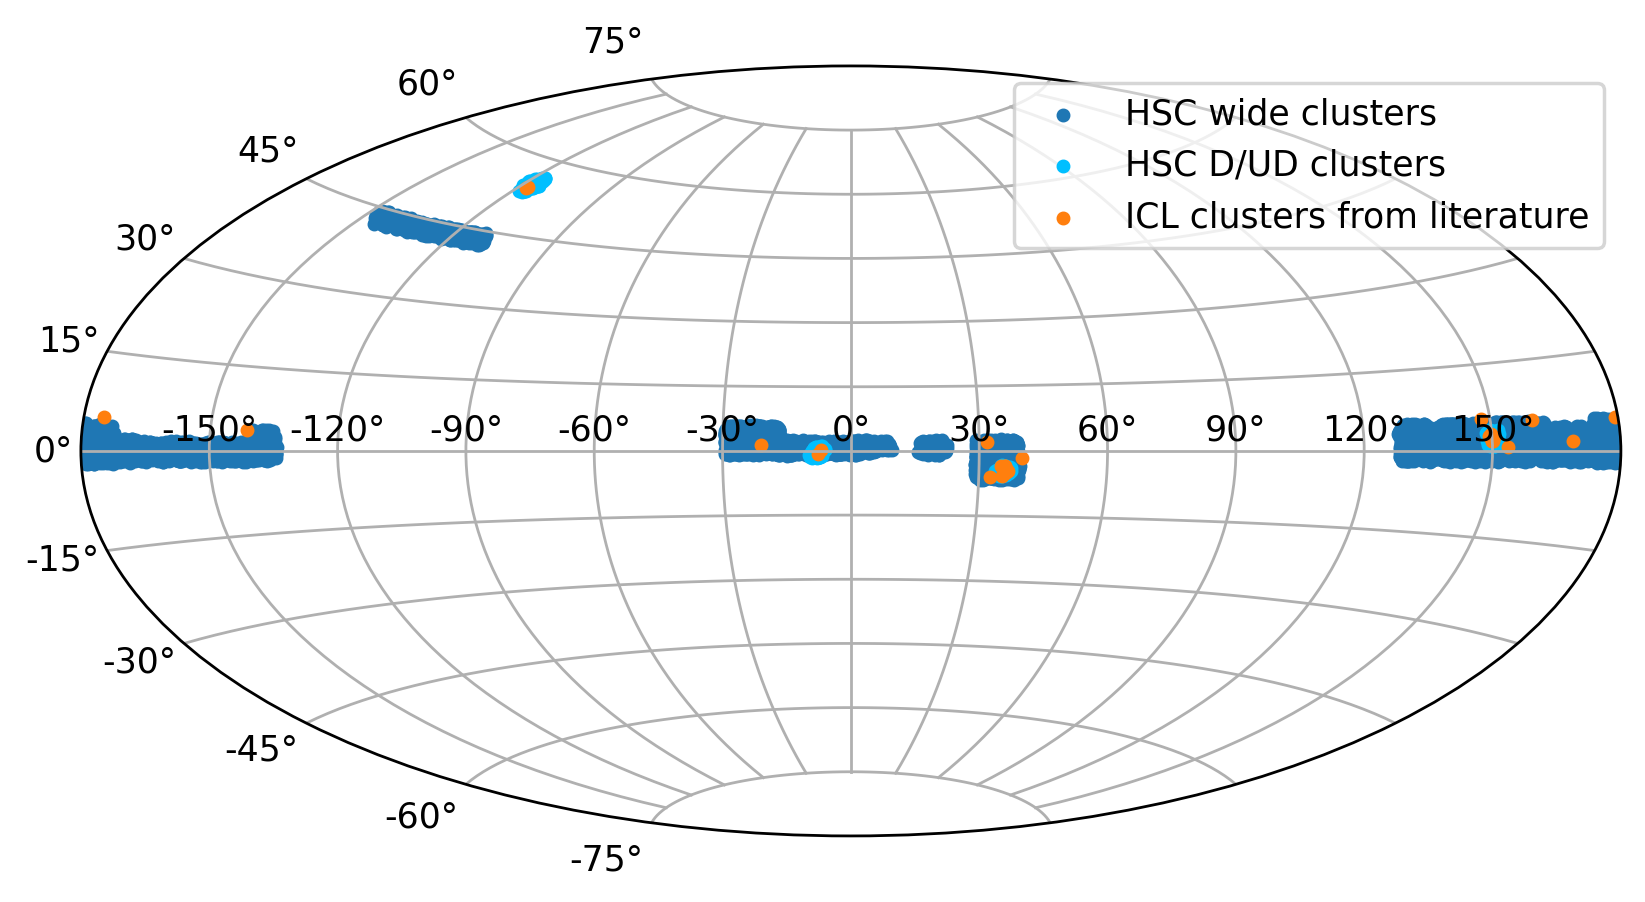

In [5]:
# Plot both sets of coordinates
hsc_ra = hsc_coords.icrs.ra.wrap_at(180*u.deg).radian
hsc_dec = hsc_coords.icrs.dec.radian

hsc_dud_ra = hsc_dud_coords.icrs.ra.wrap_at(180*u.deg).radian
hsc_dud_dec = hsc_dud_coords.icrs.dec.radian

icl_ra = icl_coords.icrs.ra.wrap_at(180*u.deg).radian
icl_dec = icl_coords.icrs.dec.radian

fig = plt.figure(figsize=(8,4), dpi=250)
plt.subplot(111, projection='aitoff')
plt.grid(True)
plt.scatter(hsc_ra, hsc_dec, marker='.')
plt.scatter(hsc_dud_ra, hsc_dud_dec, marker='.', color="deepskyblue")
plt.scatter(icl_ra, icl_dec, marker='.')
plt.legend(["HSC wide clusters", "HSC D/UD clusters", "ICL clusters from literature"])
plt.show()

In [6]:
# Try to cross-match
idx_hsc, idx_icl, sep, dist = icl_coords.search_around_sky(hsc_coords, 25*u.arcsec)

print(len(idx_hsc)) 
# :/

9


## Compare redshift distributions
<a id='redshift'></a>

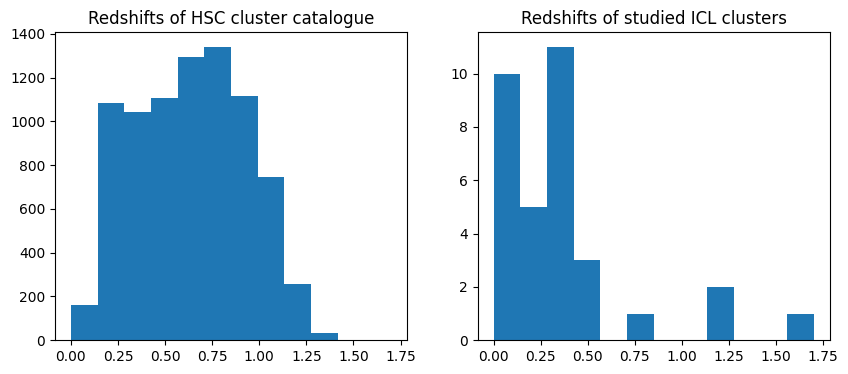

In [7]:
# Check the distribution of redshifts
icl_z = data["Redshift"]

plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
num, bins, _ = plt.hist(zs, bins=np.linspace(0, 1.7, 13))
plt.title("Redshifts of HSC cluster catalogue")
plt.subplot(1, 2, 2)
plt.hist(icl_z, bins=np.linspace(0, 1.7, 13))
plt.title("Redshifts of studied ICL clusters")
plt.show()

In [18]:
z_arr = np.array(zs)
print(f"{len(z_arr[z_arr <= 0.5])} clusters with redshift <= 0.5")

print(f"{len(z_arr[z_arr < 0.6])} clusters with redshift below z < 0.6") 

2846 clusters with redshift <= 0.5
3702 clusters with redshift below z < 0.6


## Match wide and DUD catalogues

In [11]:
# There should be a bunch of clusters in DUD that are repeated in WIDE because of the overlap.
# Try to cross-match the two catalogues
idx_dud, idx_wide, sep, dist = hsc_coords.search_around_sky(hsc_dud_coords, 25*u.arcsec)

# Remove the ELAIS-N1 field from the DUD catalogue to calculate number of expected matches
# (since this is the only field with no overlap with the wide survey)
not_elais = hsc_dud_coords[hsc_dud_coords.separation(SkyCoord(242, 55, unit=u.deg)) > 10*u.deg]

print(f"{len(idx_dud)} matches made out of {len(not_elais)} possible matches")

# Is this a reasonable number?
# Plot it, or maybe check for ambiguous matches? 
_, cts = np.unique(idx_dud, return_counts=True)
print(f"Number of wide clusters that are matched by multiple deep clusters = {len(cts[cts > 1])}")
_, cts = np.unique(idx_wide, return_counts=True)
print(f"Number of deep clusters that are matched by multiple wide clusters = {len(cts[cts > 1])}")

91 matches made out of 162 possible matches
Number of wide clusters that are matched by multiple deep clusters = 0
Number of deep clusters that are matched by multiple wide clusters = 0


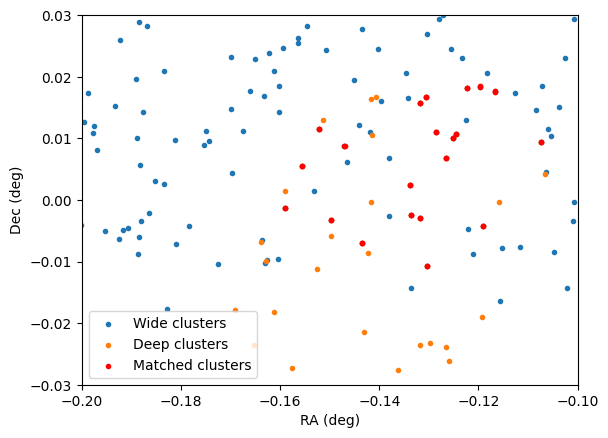

In [12]:
# Want to plot the various deep fields - starting with the DEEP2-3 field
cen = SkyCoord(-7.5, 0, unit=u.deg)

deep23 = hsc_dud_coords[hsc_dud_coords.separation(cen) < 5*u.deg]
deep23_wide = hsc_coords[hsc_coords.separation(cen) < 10*u.deg]
idx_dud, idx_wide, sep, dist = deep23_wide.search_around_sky(deep23, 1*u.arcmin)
matched_dud = deep23[idx_dud]
matched_wide = deep23_wide[idx_wide]

plt.scatter(deep23_wide.ra.wrap_at(180*u.deg).radian, deep23_wide.dec.radian, marker='.')
plt.scatter(deep23.ra.wrap_at(180*u.deg).radian, deep23.dec.radian, marker='.')
plt.scatter(matched_wide.ra.wrap_at(180*u.deg).radian, matched_wide.dec.radian, marker='.', color="red")
plt.scatter(matched_dud.ra.wrap_at(180*u.deg).radian, matched_dud.dec.radian, marker='.', color="red")
plt.xlabel("RA (deg)")
plt.ylabel("Dec (deg)")
plt.legend(["Wide clusters", "Deep clusters", "Matched clusters"])
plt.xlim(-0.2, -0.1)
plt.ylim(-0.03, 0.03)
plt.show()

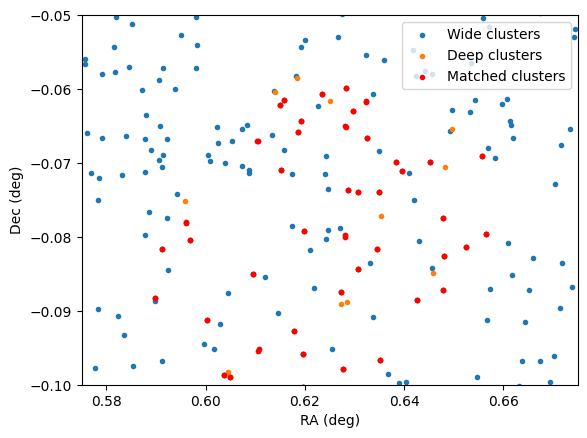

In [13]:
# Clusters in SXDS field
cen = SkyCoord(35, -5, unit=u.deg)

sxds = hsc_dud_coords[hsc_dud_coords.separation(cen) < 5*u.deg]
sxds_wide = hsc_coords[hsc_coords.separation(cen) < 10*u.deg]

idx_dud, idx_wide, sep, dist = sxds_wide.search_around_sky(sxds, 1*u.arcmin)
matched_dud = sxds[idx_dud]
matched_wide = sxds_wide[idx_wide]

plt.scatter(sxds_wide.ra.wrap_at(180*u.deg).radian, sxds_wide.dec.radian, marker='.')
plt.scatter(sxds.ra.wrap_at(180*u.deg).radian, sxds.dec.radian, marker='.')
plt.scatter(matched_wide.ra.wrap_at(180*u.deg).radian, matched_wide.dec.radian, marker='.', color="red")
plt.scatter(matched_dud.ra.wrap_at(180*u.deg).radian, matched_dud.dec.radian, marker='.', color="red")
plt.xlabel("RA (deg)")
plt.ylabel("Dec (deg)")
plt.xlim(0.575, 0.675)
plt.ylim(-0.1, -0.05)
plt.legend(["Wide clusters", "Deep clusters", "Matched clusters"])
plt.show()

## Investigate richness and mass

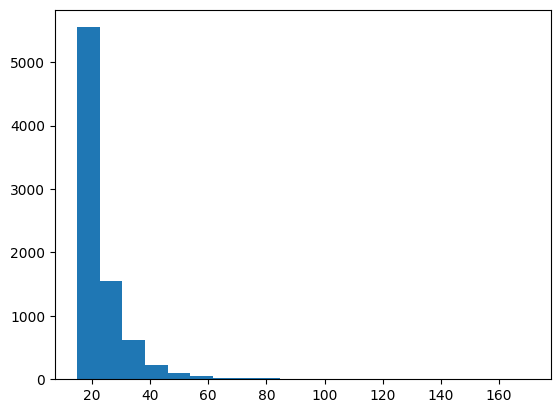

In [14]:
# Plot a richness histogram
plt.hist(richnesses, bins=20)
plt.show()

In [15]:
# Find richnesses of the matched clusters
l = list(hsc_coords.ra) + list(hsc_dud_coords.ra)
all_coords = SkyCoord(list(hsc_coords.ra) + list(hsc_dud_coords.ra), list(hsc_coords.dec) + list(hsc_dud_coords.dec), unit=(u.deg, u.deg))

idx_hsc, idx_icl, sep, dist = icl_coords.search_around_sky(all_coords, 25*u.arcsec)
# Remove the duplicate matches
# idx_icl, unique_indices = np.unique(idx_icl, return_index=True)
# idx_hsc = idx_hsc[unique_indices]

masses = data.iloc[idx_icl]["Mass (10^14 M_solar)"]
data.iloc[idx_icl]

,Paper,Link,Cluster,RA,DEC,Unnamed: 5,HSC-Wide?,HSC-DUD?,Mass (10^14 M_solar),Redshift,...,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Mass from
11,Burke et al. (2012),https://ui.adsabs.harvard.edu/abs/2012MNRAS.42...,XLSS J0223,2h23m03s,-4d36m22s,hms,Y,Y,1.800,0.830,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,NaN,NaN,XLSS J0224,2h24m00s,-3d25m34s,hms,Y,Y,2.300,1.220,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,NaN,NaN,XMMXCS J022524.8−044043.4,36.353,-4.679,deg,Y,Y,0.917,0.264,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,NaN,NaN,XMMXCS J022530.8−041421.1,36.378,-4.239,deg,Y,Y,0.602,0.143,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,NaN,NaN,XMMXCS J095901.2+024740.4,149.755,2.794,deg,Y,Y,0.327,0.501,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,NaN,NaN,XMMXCS J095902.7+025544.9,149.761,2.929,deg,Y,Y,1.836,0.349,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,NaN,NaN,XMMXCS J095951.2+014045.8,149.963,1.679,deg,Y,Y,0.734,0.372,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,Ko & Jee (2018),https://iopscience.iop.org/article/10.3847/153...,MOO J1014+0038,10h14m08.4000s,+00d38m26.000s,hms,Y,N,5.600,1.240,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,NaN,NaN,XMMXCS J232923.6−004854.7,352.348,-0.815,deg,Y,Y,1.611,0.300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,NaN,NaN,XLSS J0224,2h24m00s,-3d25m34s,hms,Y,Y,2.300,1.220,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Richness	Mass
16.278		1.8
21.479		2.3
17.492		0.917
20.762		0.602
16.828		0.327
37.877		1.836
18.773		0.734
42.109		5.6
27.891		1.611
20.32		2.3
17.217		0.544
17.31		0.917
22.53		0.602
35.483		1.836
59.583		1.567


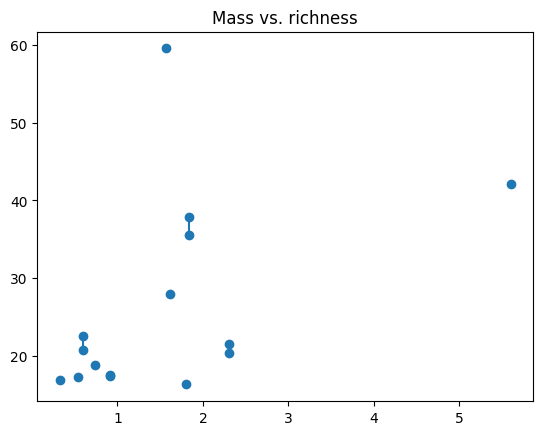

In [16]:
print("Richness\tMass")
for i in range(len(idx_hsc)):
    print(f"{richnesses[idx_hsc[i]]}\t\t{masses.tolist()[i]}")

# Plot richness against mass
plt.scatter(masses.tolist(), np.array(richnesses)[idx_hsc])

# Mark the clusters that match to both DUD and WIDE catalogues
uniques, counts = np.unique(masses.tolist(), return_counts=True)
doubles = uniques[counts > 1]
for num in doubles:
    r = np.array(richnesses)[idx_hsc][np.where(masses.tolist() == num)[0]]
    plt.plot([num, num], r, color='C0')

plt.title("Mass vs. richness")
plt.show()